In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -qqq ipyplot

In [3]:
import os
import numpy as np 
import pandas as pd 
import glob
import cv2
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import random
from ipyplot import plot_images

import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from PIL import Image

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
path = '/kaggle/input/shift-cv-winter-2023/train/train/'

Необходимо, чтобы результат был воспроизводим

In [4]:
import random 
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Определим функции и классы для работы с данными

In [5]:
def read_image(path: str):
    return cv2.imread(path)


class CustomDataset(Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df
        
    def __len__(self) -> int:
        return len(self.df)
    
    
class CustomDatasetTrainVal(CustomDataset):
    def __init__(self, df: pd.DataFrame, transform: transforms.Compose=None) -> None:
        super().__init__(df)
        self.transform = transform
    
    def __getitem__(self, idx: int):  # а как описать то, что тут аозврощается??
        image_path = self.df.filename.iloc[idx]
        image = read_image(image_path)
        if self.transform:
            image = self.transform(image)
        label = self.df.blur.iloc[idx]
        return {
            "image": image,
            "label": label,
            "path": image_path
        }


class CustomDatasetTest(CustomDataset):
    def __init__(self, df: pd.DataFrame, transform: transforms.Compose=None) -> None:
        super().__init__(df)
        self.transform = transform
    
    def __getitem__(self, idx: int):
        image_path = self.df.filename.iloc[idx]
        image = read_image(image_path)
        if self.transform:
            image = self.transform(image)
        return {
            "image": image
        }

Эксперименты показали, что аугментация исходных данных позволяет улучшить качество используемой модели

Для нормализации используем значения, полученные на Imagenet. В качестве преобразования исходных данных помимонормализаци, я выбрал только горизонтальные и вертикальные повороты, так как они не вносили лишний шум, который мог бы значительно осложнить определение заблюренного изображения

In [6]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

Загружаем датасет. Он имеет небольшой размер, поэтому для валидации оставляем только 5% данных. На предыдущих шагах при тестировании разных подходов использовалась валидация на 20% размеченных данных.

In [7]:
df_train = pd.read_csv('/kaggle/input/shift-cv-winter-2023/train.csv')
df_train['filename'] = df_train['filename'].apply(lambda x: path + x)

test_imgs = []
for file in glob.glob("/kaggle/input/shift-cv-winter-2023/test/test/*.jpg"):
    test_imgs.append({'filename': file})
df_test = pd.DataFrame(test_imgs)

df_train_, df_val_ = train_test_split(df_train, test_size=0.05, stratify=df_train.blur.values, random_state=SEED)

train_dataset = CustomDatasetTrainVal(df_train_, transform=train_transforms)
val_dataset = CustomDatasetTrainVal(df_val_, transform=test_transforms)
test_dataset = CustomDatasetTest(df_test, transform=test_transforms)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=8)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=16)

Посмотрим на данные. Метка 1 - blur, метка 0 - норма

Пример нормального изображения



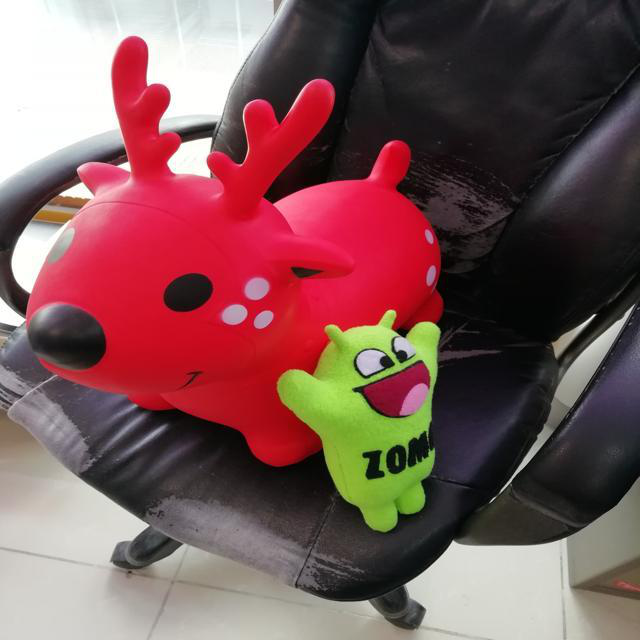


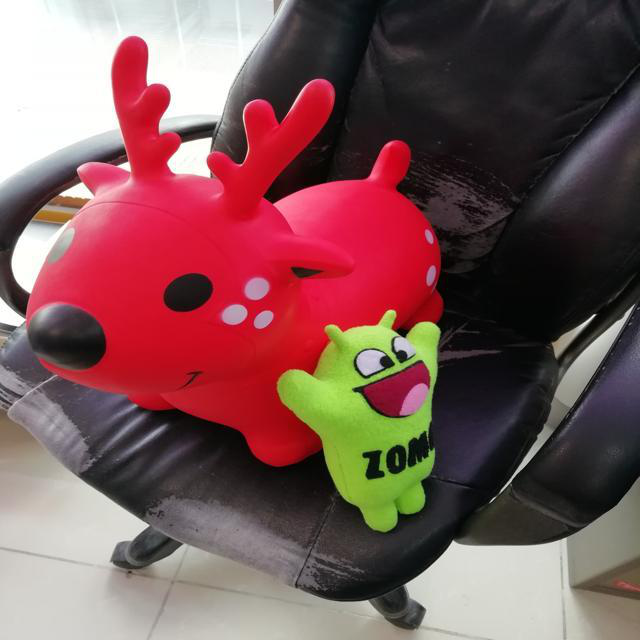

In [8]:
print("Пример нормального изображения")
image_normal = df_train[df_train.blur == 0].filename.sample(1).tolist()
plot_images(image_normal, img_width=600, force_b64=True)

Пример заблюренного изображения



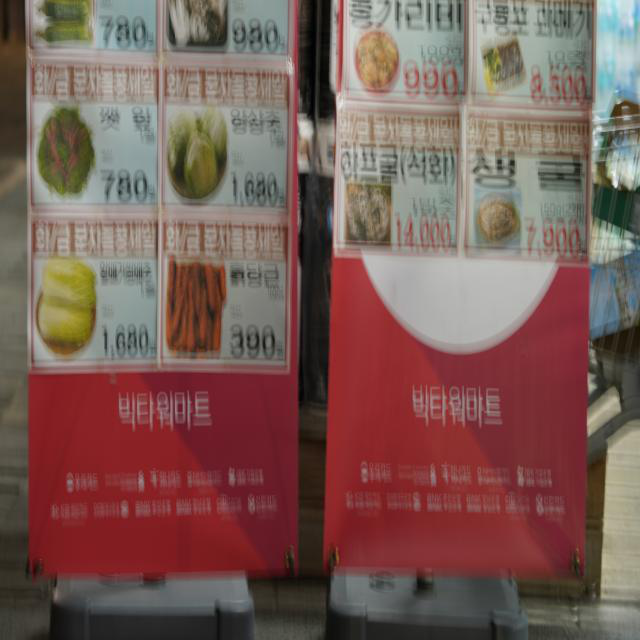


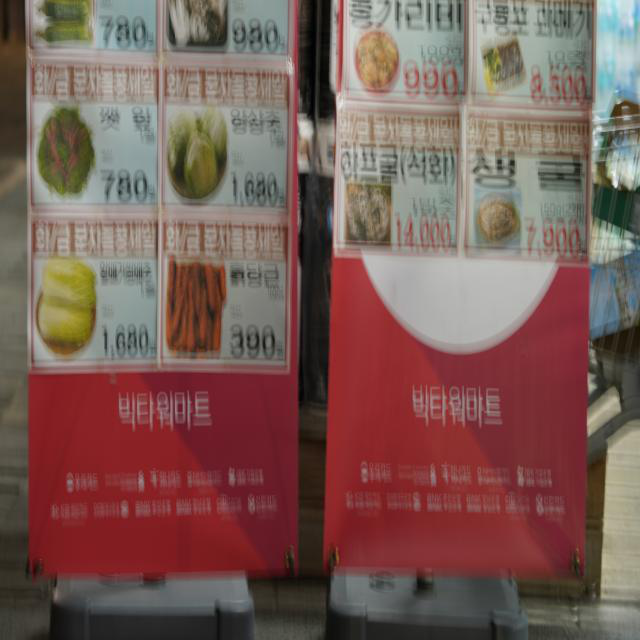

In [9]:
print("Пример заблюренного изображения")
image_normal = df_train[df_train.blur == 1].filename.sample(1).tolist()
plot_images(image_normal, img_width=600, force_b64=True)

В качестве модели используется EfficientNet_b0, предобученная на Imagenet. При обучении я оставляю возможность для изменения всех весов модели

In [10]:
model = models.efficientnet_b0(pretrained=True)
model.classifier[-1] = nn.Linear(1280, 1)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

Функция для обучения модели

In [11]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, shed=None, device=torch.device("cpu"), info=True):
    train_losses = []
    val_losses = []
    valid_accuracies = []
    auc_val_list = []
    min_auc = 0
    min_val_loss = np.inf
    
    for epoch in range(epochs):
        model.train()
        
        loss_sum_train = 0
        loss_sum_val = 0
        correct = 0
        num = 0
        for_auc = []
        for_auc_true = []
        
        for batch in tqdm(train_dl):
            xb, yb = batch["image"].to(device), batch["label"].to(device)
            # xb = xb.permute(0, 3, 1, 2)
            
            xb = xb.float()
            res = model(xb)
            
            loss = loss_func(res.squeeze(), yb)
            loss_sum_train += loss.item()
            
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        if shed:
            shed.step()
            
        model.eval()
        with torch.no_grad():
            for batch in tqdm(valid_dl):
                xb, yb = batch["image"].to(device), batch["label"].to(device)
                # xb = xb.permute(0, 3, 1, 2)
                
                xb = xb.float()
                res = model(xb)
                
                res = res.squeeze()
                
                for_auc.extend(res.tolist())
                for_auc_true.extend(yb.tolist())
                loss_sum_val += loss_func(res, yb).item()
                preds = (F.sigmoid(res) > 0.5).int()
                correct += (preds == yb).sum().item()
                num += len(xb)
        
        curr_auc = roc_auc_score(for_auc_true, for_auc)
        
        print(f"***TRAIN LOSSES - {loss_sum_train / len(train_dl)}***")
        print(f"***VAL LOSSES - {loss_sum_val / len(valid_dl)}***")
        print(f"***ACCURACY - {correct / num}***")
        print(f"***AUC - {curr_auc}***")
        
        train_losses.append(loss_sum_train / len(train_dl))
        val_losses.append(loss_sum_val / len(valid_dl))
        valid_accuracies.append(correct / num)
        auc_val_list.append(curr_auc)
        
        if curr_auc > min_auc:
            torch.save(model.state_dict(), 'model.pt')
            min_auc = curr_auc
        
    return train_losses, val_losses, valid_accuracies, auc_val_list


def eval(model, valid_dl, device):
    model.eval()
    
    probs = []
    labels = []
    imgs_paths = []
    
    with torch.no_grad():
        for batch in tqdm(valid_dl):
            xb, yb, pth = batch["image"].to(device), batch["label"].to(device), batch["path"]
            
            xb = xb.float()
            res = model(xb)
            res = res.squeeze()
            probs.extend((F.sigmoid(res)).tolist())
            labels.extend(yb.tolist())
            imgs_paths.extend(pth)
            
    return np.array(probs), np.array(labels), np.array(imgs_paths)

In [12]:
model.to(device)

criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = None

info = fit(20, model, criterion, optimizer, train_dataloader, val_dataloader, scheduler, device, True)

  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:03<00:00,  5.23it/s]


***TRAIN LOSSES - 0.5756403012028587***
***VAL LOSSES - 0.40694413552809433***
***ACCURACY - 0.8731343283582089***
***AUC - 0.9625418060200669***


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:02<00:00,  6.19it/s]


***TRAIN LOSSES - 0.3205065386260019***
***VAL LOSSES - 0.21118657033452215***
***ACCURACY - 0.9328358208955224***
***AUC - 0.9830546265328873***


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:02<00:00,  6.10it/s]


***TRAIN LOSSES - 0.23112061862929373***
***VAL LOSSES - 0.14965482510845451***
***ACCURACY - 0.9477611940298507***
***AUC - 0.9919732441471572***


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:02<00:00,  6.23it/s]


***TRAIN LOSSES - 0.1862338670473312***
***VAL LOSSES - 0.10999392866788006***
***ACCURACY - 0.9626865671641791***
***AUC - 0.9950947603121516***


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:02<00:00,  6.21it/s]


***TRAIN LOSSES - 0.16432378951130225***
***VAL LOSSES - 0.08955227721440571***
***ACCURACY - 0.9776119402985075***
***AUC - 0.9975473801560758***


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:02<00:00,  6.27it/s]


***TRAIN LOSSES - 0.12660516684195428***
***VAL LOSSES - 0.08235248939742931***
***ACCURACY - 0.9850746268656716***
***AUC - 0.9962095875139353***


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:02<00:00,  6.01it/s]


***TRAIN LOSSES - 0.10436509342797007***
***VAL LOSSES - 0.060666789974332044***
***ACCURACY - 0.9776119402985075***
***AUC - 0.9988851727982162***


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:02<00:00,  6.22it/s]


***TRAIN LOSSES - 0.10815426735731448***
***VAL LOSSES - 0.05821506806424179***
***ACCURACY - 0.9776119402985075***
***AUC - 0.9988851727982162***


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:02<00:00,  6.21it/s]


***TRAIN LOSSES - 0.08484009423873433***
***VAL LOSSES - 0.04652504398312179***
***ACCURACY - 0.9776119402985075***
***AUC - 0.9993311036789297***


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:02<00:00,  6.17it/s]


***TRAIN LOSSES - 0.06868784781873231***
***VAL LOSSES - 0.06467018030324956***
***ACCURACY - 0.9776119402985075***
***AUC - 0.999108138238573***


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:02<00:00,  6.13it/s]


***TRAIN LOSSES - 0.07880301880188846***
***VAL LOSSES - 0.03505096974397978***
***ACCURACY - 0.9850746268656716***
***AUC - 0.9995540691192866***


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:03<00:00,  5.19it/s]


***TRAIN LOSSES - 0.097305277778367***
***VAL LOSSES - 0.03490327219920301***
***ACCURACY - 0.9850746268656716***
***AUC - 0.9995540691192866***


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:02<00:00,  5.82it/s]


***TRAIN LOSSES - 0.06542086041298796***
***VAL LOSSES - 0.039849263331647296***
***ACCURACY - 0.9850746268656716***
***AUC - 0.9995540691192866***


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:03<00:00,  5.42it/s]


***TRAIN LOSSES - 0.08347543527571749***
***VAL LOSSES - 0.03781479593549288***
***ACCURACY - 0.9850746268656716***
***AUC - 0.9997770345596433***


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:02<00:00,  6.17it/s]


***TRAIN LOSSES - 0.046077012574646845***
***VAL LOSSES - 0.030089554884490766***
***ACCURACY - 0.9925373134328358***
***AUC - 1.0***


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:03<00:00,  5.60it/s]


***TRAIN LOSSES - 0.060686895992882024***
***VAL LOSSES - 0.027491689405854034***
***ACCURACY - 0.9925373134328358***
***AUC - 1.0***


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:02<00:00,  6.31it/s]


***TRAIN LOSSES - 0.047919434998075036***
***VAL LOSSES - 0.023801344061767715***
***ACCURACY - 0.9925373134328358***
***AUC - 1.0***


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:02<00:00,  5.76it/s]


***TRAIN LOSSES - 0.05381957085210274***
***VAL LOSSES - 0.03234013375697614***
***ACCURACY - 0.9925373134328358***
***AUC - 1.0***


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:02<00:00,  6.30it/s]


***TRAIN LOSSES - 0.054535313607312806***
***VAL LOSSES - 0.026754047722089364***
***ACCURACY - 0.9925373134328358***
***AUC - 1.0***


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:03<00:00,  5.34it/s]

***TRAIN LOSSES - 0.0470051267197865***
***VAL LOSSES - 0.01989884939998416***
***ACCURACY - 0.9925373134328358***
***AUC - 1.0***


Построим графики

In [13]:
train_losses, val_losses, valid_accuracies, auc_val_list = info[0], info[1], info[2], info[3]

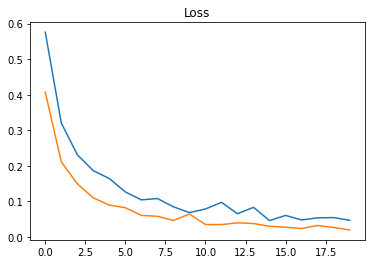

In [14]:
plt.title("Loss")
plt.plot(train_losses)
plt.plot(val_losses);

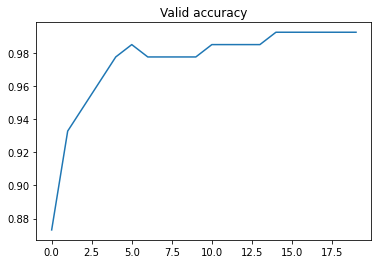

In [15]:
plt.title("Valid accuracy")
plt.plot(valid_accuracies);

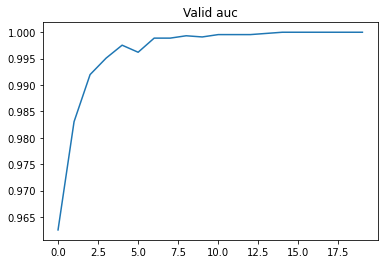

In [16]:
plt.title("Valid auc")
plt.plot(auc_val_list);

Посмотрим на неправильно классифицированные картинки

In [17]:
probs, labels, imgs_paths = eval(model, val_dataloader, device)

  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 17/17 [00:02<00:00,  6.39it/s]


In [18]:
# выдали слишком маленькую вероятность для положительного класса(false negative)
k1 = probs < 0.5
k2 = labels == 1
fn = k1 & k2
print(imgs_paths[fn])

['/kaggle/input/shift-cv-winter-2023/train/train/bmhkxokpznhxtizmfboj.jpg']



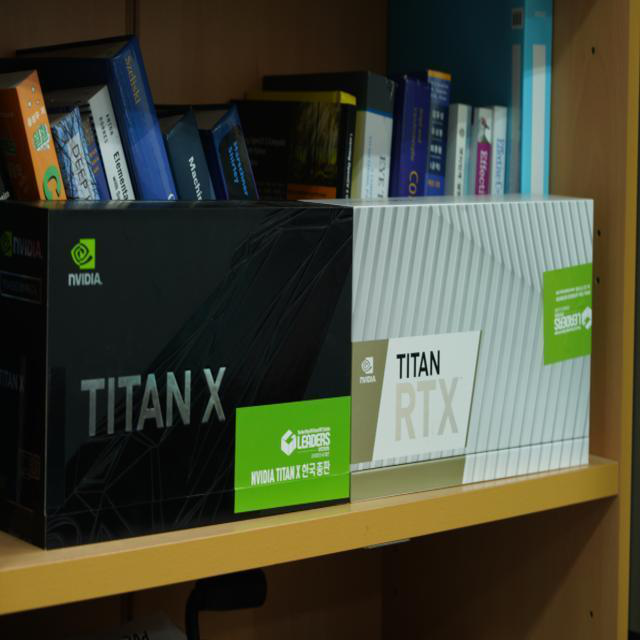


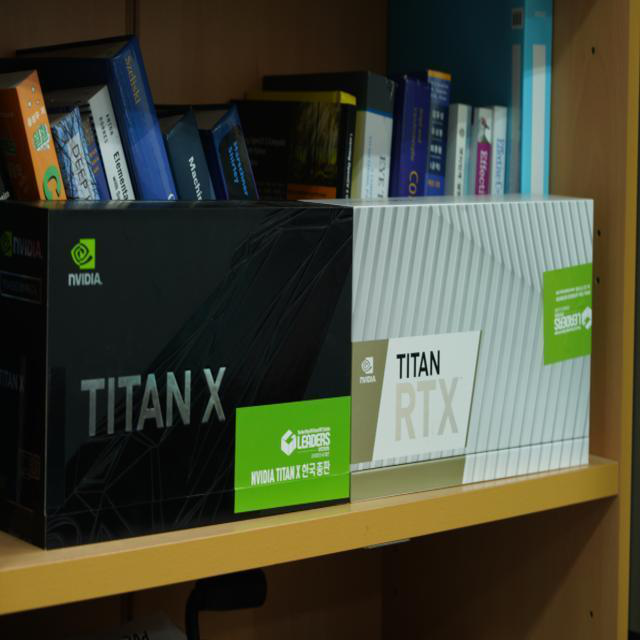

In [19]:
try:
    plot_images(imgs_paths[fn], max_images=10, img_width=600, force_b64=True)
except:
    print("Ошибки данного рода отсутствуют на валидационном наборе")

In [20]:
# выдал слишком большую вероятность для отрицательного класса(false positive)
k1 = probs >= 0.5
k2 = labels == 0
fp = k1 & k2
print(imgs_paths[fp])

[]


In [21]:
try:
    plot_images(imgs_paths[fp], max_images=10, img_width=600, force_b64=True)
except:
    print("Ошибки данного рода отсутствуют на валидационном наборе")

Ошибки данного рода отсутствуют на валидационном наборе


Обработаем тестовые данные

In [22]:
predicts = []

model.load_state_dict(torch.load('model.pt'))
model.eval()
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        xb = batch["image"].to(device)
        
        # xb = xb.permute(0, 3, 1, 2)
        
        xb = xb.float()
                
        res = model(xb)
                
        res = res.squeeze()
        res = F.sigmoid(res)
        
        predicts.extend(res.tolist())
        
df_test['blur'] = predicts
df_test['filename'] = df_test['filename'].apply(lambda x : os.path.split(x)[1])
df_test.to_csv('/kaggle/working/submission.csv', index=False)

100%|██████████| 49/49 [00:18<00:00,  2.62it/s]
